In [1]:
### Import modules 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score,accuracy_score,mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor,plot_importance

%matplotlib inline 

In [2]:
path = "/media/danlof/dan_files/data_science_codes/medical_insurance/data/Medical_insurance.csv"
df = pd.read_csv(path)

### Exploratory Data analysis


In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#### Numerical features

In [4]:
df.describe()

,age,bmi,children,charges
count,2772.000000,2772.000000,2772.000000,2772.000000
mean,39.109668,30.701349,1.101732,13261.369959
std,14.081459,6.129449,1.214806,12151.768945
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4687.797000
50%,39.000000,30.447500,1.000000,9333.014350
75%,51.000000,34.770000,2.000000,16577.779500
max,64.000000,53.130000,5.000000,63770.428010


Statistics for the numerical columns
- `age` - Contains values between the ages of 18-64 suggesting we are only considering adults.
- `bmi`- It spans from 16 to 53 with a mean of 31, it also has a large range of 37.17(53.13−15.96) suggesting presence of outliers and variability. There is also the IQR of 8.55( 34.77−26.22) which indicates the spread of data in the middle half of the data is quite moderate. The difference between the median (30.447) and mean (30.7) suggest a slight skewness.

- `children` - is a discrete numerical variable, where people in the dataset have between 0- 5 kids and most of them having 1 kid.
- `charges` - the target variable spans a wide range from  1122 to 63770, and it also seems to be quite skewed considering the mean and median.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


- This seems to a rather small data set with 2772 rows and 7 columns.
- There are no missing values from the dataset 
- The features consist of 3 numerical variables and 3 categorical variables, meaning some encoding needs to be done on the categorical variables.
- 

#### Categorical features

<Axes: xlabel='sex', ylabel='count'>

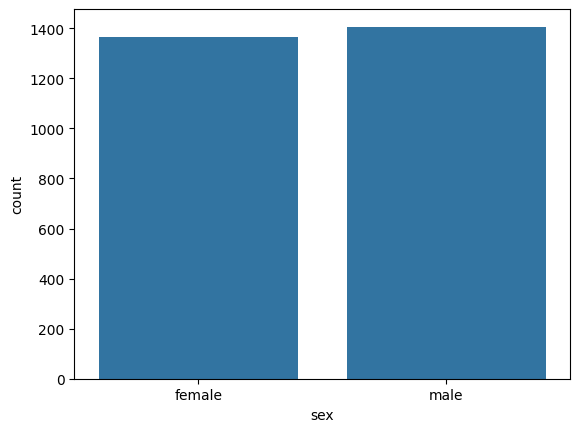

In [6]:
sns.countplot(x=df['sex'])

This countplot show that there is an equal represntation of both males and females.

<Axes: xlabel='smoker', ylabel='count'>

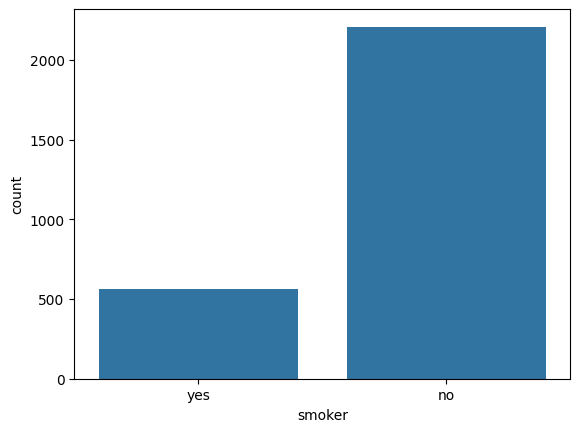

In [7]:
sns.countplot(x=df['smoker'])

There seems to be 4 times more non-smokers compared to smokers 

<Axes: xlabel='region', ylabel='count'>

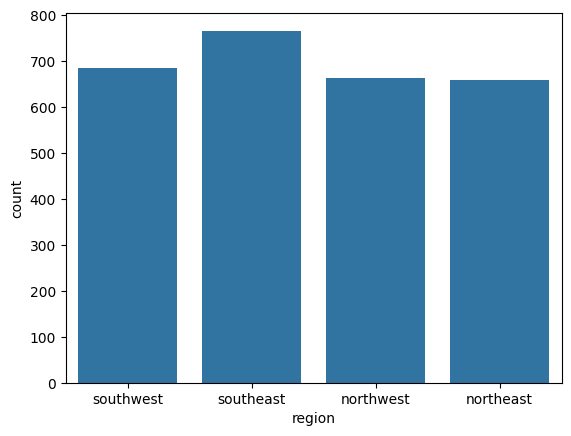

In [8]:
sns.countplot(x=df['region'])

There seems to be almost equal representation from all the regions.

### Data Preprocessing

- Only encoding of the categorical features is needed 

In [9]:
df=pd.get_dummies(df,columns=["sex", "smoker", "region"],drop_first=True)

#### Correlation analysis

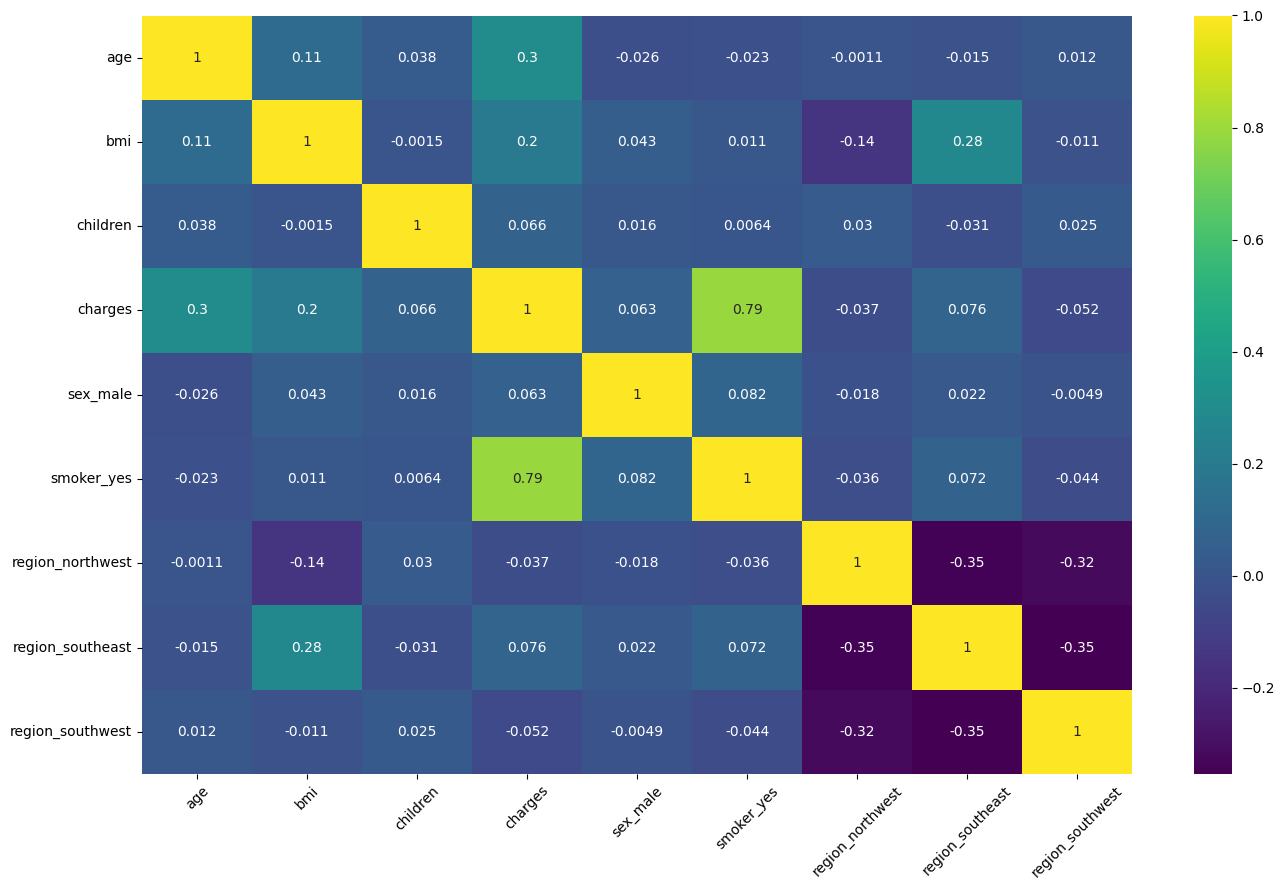

In [10]:
plt.figure(figsize=(14,9))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='viridis')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

There is a positive correlation between charges and smokers suggesting higher terms for smokers.Since they are more at risk

#### Train Test split

In [11]:
X_train,X_test,y_train,y_test = train_test_split(df.drop('charges',axis=1).values,
                                                 df['charges'].values,train_size=0.8)

### Model

- Creating a XGBRegressor object for prediction of the continuous variables

In [12]:
rf = RandomForestRegressor(random_state=4)

In [13]:
# Parameter grid for hyperparameter tuning using the XGBoost library

param_grid = {
    'n_estimators': np.arange(50, 500, 50),
    'max_depth': np.arange(3, 20, 2),
    'min_samples_split': np.arange(2, 10),
    'min_samples_leaf': np.arange(1, 10),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [14]:
# for cross-validation we use the kfold method

kf = KFold(n_splits=5, shuffle = True, random_state = 4)

In [15]:
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50, 
    scoring='neg_root_mean_squared_error',  # RMSE as the evaluation metric
    n_jobs=-1,  # Use all available cores
    cv=kf.split(X_train,y_train), 
    verbose=1,
    random_state=4,
)

In [16]:
# fit the model 

random_search.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/media/danlof/dan_files/data_science_codes/medical_insurance/insurance/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
95 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
33 fits failed with the following error:
Traceback (most recent call last):
  File "/media/danlof/dan_files/data_science_codes/medical_insurance/insurance/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/media/danlof/dan_files/data_science_codes/medical_insurance/insurance/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/media

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f38eb1719a0>,
                   estimator=RandomForestRegressor(random_state=4), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450])},
                   random_state=4, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [17]:
# best model

best_rf = random_search.best_estimator_

In [18]:
# predict on the test set
y_pred = best_rf.predict(X_test)

In [19]:
print(f"Accuracy on test data : {r2_score(y_test,y_pred)*100:.2f}")

Accuracy on test data : 97.70


#### XGBRegressor Model


In [20]:
xgb = XGBRegressor()
xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [21]:
print(f"Accuracy on Test Data: {r2_score(y_test,y_pred)*100:.2f}")

Accuracy on Test Data: 97.70


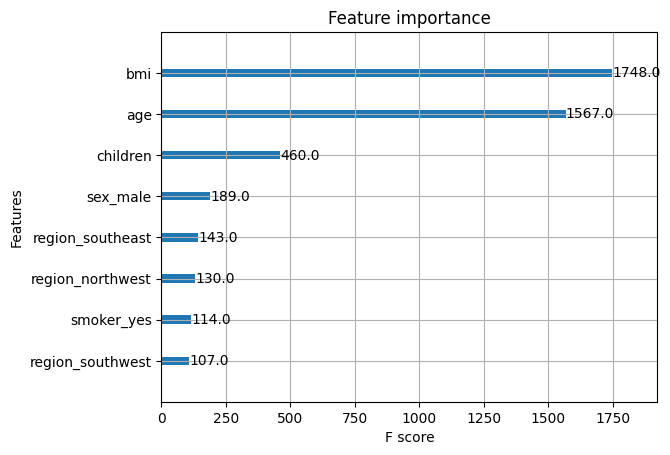

In [22]:
xgb.get_booster().feature_names = list(df.drop('charges',axis=1).columns)

plot_importance(xgb)
plt.show()

- From the plot we see that `bmi` and `age` are the most important features for this model.